# §1: Setup and data

In [28]:
# Import libraries
from google.cloud import bigquery
from google.cloud import bigquery_storage

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

In [5]:
# Setup Google Cloud credentials
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service-account-key.json"

# Store the service key in the corresponding location in colab files
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/kamronaggor/Desktop/Desktop/Manual Library/School/URI/Fall 2025/DSP 461/Machine-Learning-Final/credentials/machine-learning-final-477822-031ba3aac2f9.json'

## Loading data from Bigquery
Here we use the bigquery library to send requests to bq api where our data is stored

In [6]:
load_dotenv()

from google.cloud import bigquery
client = bigquery.Client(project="machine-learning-final-477822")

## Creating our Dataframes

In [15]:
# Query the full ACS census tract table:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""

# Run query
query_job = client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

Loaded ACS dataframe with shape: (85395, 245)


,geo_id,aggregate_travel_time_to_work,amerindian_including_hispanic,amerindian_pop,armed_forces,asian_including_hispanic,asian_male_45_54,asian_male_55_64,asian_pop,associates_degree,...,vacant_housing_units,vacant_housing_units_for_rent,vacant_housing_units_for_sale,walked_to_work,white_including_hispanic,white_male_45_54,white_male_55_64,white_pop,worked_at_home,workers_16_and_over
0,1001020200,18595.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,72.0,...,147.0,32.0,0.0,0.0,647.0,89.0,32.0,641.0,10.0,700.0
1,1001020300,47570.0,0.0,0.0,21.0,44.0,0.0,0.0,44.0,243.0,...,113.0,0.0,0.0,34.0,2363.0,143.0,232.0,2363.0,32.0,1959.0
2,1001020400,37660.0,10.0,10.0,10.0,17.0,0.0,0.0,17.0,257.0,...,105.0,23.0,25.0,28.0,3097.0,121.0,258.0,3085.0,45.0,1583.0
3,1001020503,28605.0,0.0,0.0,96.0,18.0,0.0,0.0,18.0,252.0,...,0.0,0.0,0.0,22.0,2397.0,218.0,105.0,2397.0,121.0,1606.0
4,1001020600,23255.0,0.0,0.0,40.0,11.0,0.0,0.0,11.0,145.0,...,134.0,43.0,22.0,6.0,2667.0,193.0,176.0,2551.0,80.0,1212.0


In [16]:
# From here we filter into DP05 and DP03 as needed for analysis

# DP03: Economic features
dp03_cols = [
    "median_income",
    "income_per_capita",
    "poverty",
    "pop_in_labor_force",
    "employed_pop",
    "unemployed_pop",
    "not_in_labor_force",
    "commuters_16_over",
    "aggregate_travel_time_to_work",
    "commute_less_10_mins",
    "commute_5_9_mins",
    "commute_10_14_mins",
    "commute_15_19_mins",
    "commute_20_24_mins",
    "commute_25_29_mins",
    "commute_30_34_mins",
    "commute_35_39_mins",
    "commute_40_44_mins",
    "commute_45_59_mins",
    "commute_60_more_mins",
    "worked_at_home",
    "walked_to_work",
    "no_car",
    "one_car",
    "two_cars",
    "three_cars",
    "four_more_cars",
    "gini_index",
]

# DP05: Demographic features
dp05_cols = [
    "total_pop",
    "male_pop",
    "female_pop",
    "male_under_5",
    "male_5_to_9",
    "male_10_to_14",
    "male_15_to_17",
    "male_18_to_19",
    "male_20",
    "male_21",
    "male_22_to_24",
    "male_25_to_29",
    "male_30_to_34",
    "male_35_to_39",
    "male_40_to_44",
    "male_45_to_49",
    "male_50_to_54",
    "male_55_to_59",
    "male_60_to_61",
    "male_62_to_64",
    "male_65_to_66",
    "male_67_to_69",
    "male_70_to_74",
    "male_75_to_79",
    "male_80_to_84",
    "male_85_and_over",
    "female_under_5",
    "female_5_to_9",
    "female_10_to_14",
    "female_15_to_17",
    "female_18_to_19",
    "female_20",
    "female_21",
    "female_22_to_24",
    "female_25_to_29",
    "female_30_to_34",
    "female_35_to_39",
    "female_40_to_44",
    "female_45_to_49",
    "female_50_to_54",
    "female_55_to_59",
    "female_60_to_61",
    "female_62_to_64",
    "female_65_to_66",
    "female_67_to_69",
    "female_70_to_74",
    "female_75_to_79",
    "female_80_to_84",
    "female_85_and_over",
    "white_pop",
    "black_pop",
    "asian_pop",
    "amerindian_pop",
    "other_race_pop",
    "two_or_more_races_pop",
    "hispanic_pop",
    "white_including_hispanic",
    "black_including_hispanic",
    "asian_including_hispanic",
]

In [17]:
# Create the DFs
dp03_df = acs_df[["geo_id"] + dp03_cols].copy()

dp05_df = acs_df[["geo_id"] + dp05_cols].copy()

dp03_df.head(), dp05_df.head()

(       geo_id  median_income  income_per_capita  poverty  pop_in_labor_force  \
 0  1001020200        49144.0            22772.0    257.0               729.0   
 1  1001020300        62423.0            25291.0    533.0              2015.0   
 2  1001020400        64310.0            47056.0    281.0              1668.0   
 3  1001020503        81165.0            40522.0    319.0              1670.0   
 4  1001020600        43030.0            24783.0    831.0              1263.0   
 
    employed_pop  unemployed_pop  not_in_labor_force  commuters_16_over  \
 0         688.0            29.0               721.0              690.0   
 1        1941.0            53.0               915.0             1927.0   
 2        1619.0            39.0              1391.0             1538.0   
 3        1547.0            27.0              1134.0             1485.0   
 4        1189.0            34.0              1548.0             1132.0   
 
    aggregate_travel_time_to_work  ...  commute_45_59_mins  

# §2: Cleaning

In [24]:
# Create target variable 'high_rent_burden' 
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30

acs_df['high_rent_burden'].head()

0     True
1    False
2    False
3    False
4    False
Name: high_rent_burden, dtype: bool

In [18]:
# Dim and shape
acs_df.shape
acs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Columns: 245 entries, geo_id to workers_16_and_over
dtypes: float64(244), object(1)
memory usage: 159.6+ MB


In [19]:
# Handling Sentinel Codes:
sentinel_values = [-666666666, -777777777, -888888888, -999999999]
acs_df.replace(sentinel_values, pd.NA, inplace=True)

In [20]:
acs_df["county_fips"] = acs_df["geo_id"].str[:5] # We can now visualize by county

(array([ 154., 1030., 4300., 8738., 9671., 8988., 8209., 6593., 5589.,
        5309., 4210., 3648., 2577., 2420., 2110., 1408.,  852.,  817.,
         795.,  544.,  364.,  322.,  305.,  187.,  139.,  128.,  139.,
          89.,   61.,  220.]),
 array([  99. ,  212.4,  325.8,  439.2,  552.6,  666. ,  779.4,  892.8,
        1006.2, 1119.6, 1233. , 1346.4, 1459.8, 1573.2, 1686.6, 1800. ,
        1913.4, 2026.8, 2140.2, 2253.6, 2367. , 2480.4, 2593.8, 2707.2,
        2820.6, 2934. , 3047.4, 3160.8, 3274.2, 3387.6, 3501. ]),
 <BarContainer object of 30 artists>)

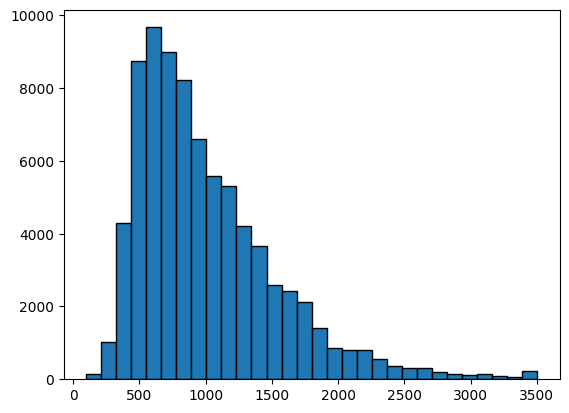

In [21]:
# Take a look at median_rent distribution
import matplotlib.pyplot as plt
plt.hist(acs_df['median_rent'].dropna(), bins=30, edgecolor='k')

In [22]:
# Examine data types
acs_df.dtypes

geo_id                            object
aggregate_travel_time_to_work     object
amerindian_including_hispanic    float64
amerindian_pop                   float64
armed_forces                     float64
                                  ...   
white_male_55_64                 float64
white_pop                        float64
worked_at_home                   float64
workers_16_and_over              float64
county_fips                       object
Length: 246, dtype: object

In [25]:
# We need to convert some columns to numeric
# We need to cast geo_id and high_rent_burden:
acs_df["geo_id"] = acs_df["geo_id"].astype(str)
acs_df["county_fips"] = acs_df["county_fips"].astype(str)
acs_df["high_rent_burden"] = acs_df["high_rent_burden"].astype(int)
acs_df["gini_index"] = pd.to_numeric(acs_df["gini_index"], errors='coerce')
acs_df["income_per_capita"] = pd.to_numeric(acs_df["income_per_capita"], errors='coerce')
acs_df["median_age"] = pd.to_numeric(acs_df["median_age"], errors='coerce')
acs_df["median_income"] = pd.to_numeric(acs_df["median_income"], errors='coerce')
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors='coerce')
acs_df["median_year_structure_built"] = pd.to_numeric(acs_df["median_year_structure_built"], errors='coerce')
acs_df["owner_occupied_housing_units_lower_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_lower_value_quartile"], errors='coerce')
acs_df["owner_occupied_housing_units_median_value"] = pd.to_numeric(acs_df["owner_occupied_housing_units_median_value"], errors='coerce')
acs_df["owner_occupied_housing_units_upper_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_upper_value_quartile"], errors='coerce')
acs_df["percent_income_spent_on_rent"] = pd.to_numeric(acs_df["percent_income_spent_on_rent"], errors='coerce')
acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"] = pd.to_numeric(acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"], errors='coerce')

Some of these measures are not really useful as pure counts, such as `unemployment_pop`, `vacant_housing_units`, etc. This is because they will end up dominating the model and also make it difficult to generalize across other areas of the country. Rather, we should insert corresponding rates columns:

In [27]:
acs_df["unemployment_rate"] = acs_df["unemployed_pop"] / acs_df["civilian_labor_force"]
acs_df["vacancy_rate"] = acs_df["vacant_housing_units"] / acs_df["occupied_housing_units"]
acs_df["renter_share"] = acs_df["housing_units_renter_occupied"] / acs_df["occupied_housing_units"]

Another issue to account for in this step is how predictors will weight numerical values. For instance, columns like `gini_index` and the rates we just defined will contain small numbers while populations will contain large scalars.

In [68]:
# Copy for scaling
df_scaled = acs_df.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns.drop("high_rent_burden")

# Scale only the numerical columns
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

df_scaled.head()

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [69]:
# Handling null values for economic data
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# build RI DP03 frame from the *scaled* df
dp03_df = df_scaled[["geo_id"] + dp03_cols + ["high_rent_burden"]].copy()

economic_data = dp03_df.drop(columns=["geo_id"])

# Separate X and y
X_raw = economic_data.drop(columns=["high_rent_burden"]).copy()
y = economic_data["high_rent_burden"].values

# Convert pandas NA -> np.nan and ensure numeric dtype
X_raw = X_raw.replace({pd.NA: np.nan})

# (optional but extra safe) coerce everything to numeric
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")

# Impute missing values with median
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(X_raw)   # works now, only np.nan inside

print("X shape:", X.shape)
print("X min/max:", np.min(X), np.max(X))

/var/folders/nr/1wbv5xqn4jdg9fpmdqblsv_w0000gn/T/ipykernel_40285/1115212583.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_raw = X_raw.replace({pd.NA: np.nan})


X shape: (85395, 28)
X min/max: 0.0 489580.0


In [70]:
# Same for demographic data
# Handling null values for economic data
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# build RI DP03 frame from the *scaled* df
dp05_df_ri = df_scaled[["geo_id"] + dp05_cols + ["high_rent_burden"]].copy()

economic_data = dp05_df_ri.drop(columns=["geo_id"])

# Separate X and y
X_raw = economic_data.drop(columns=["high_rent_burden"]).copy()
y = economic_data["high_rent_burden"].values

# Convert pandas NA -> np.nan and ensure numeric dtype
X_raw = X_raw.replace({pd.NA: np.nan})

# (optional but extra safe) coerce everything to numeric
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")

# Impute missing values with median
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(X_raw)   # works now, only np.nan inside

print("X shape:", X.shape)
print("X min/max:", np.min(X), np.max(X))

X shape: (85395, 59)
X min/max: 0.0 39373.0


# §3: Exploratory Data Analysis

## DP03 - ACS Economic Characteristics

In [71]:
dp03_df_ri = df_scaled[["geo_id"] + dp03_cols + ["high_rent_burden"]].copy()

## DP05 - ACS Demographic and Housing Characteristics

In [72]:
dp05_df_ri = df_scaled[["geo_id"] + dp05_cols + ["high_rent_burden"]].copy()

§4: Modeling

In [73]:
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# ggplot style
plt.style.use('ggplot')

In [74]:
# Load data
economic_data = dp03_df_ri.drop(columns=["geo_id"])
economic_data = economic_data.dropna()
demographic_data = dp05_df_ri.drop(columns=["geo_id"])
demographic_data = demographic_data.dropna()

In [75]:
# First, economic data
data = economic_data
X, y = data.drop(columns=["high_rent_burden"]).values, data["high_rent_burden"].values
# inspect data dimensions
print(f'Raw dataset: X shape={X.shape}, y shape={y.shape}')
# inspect feature rage
print(X.min(), X.max())

Raw dataset: X shape=(3191, 28), y shape=(3191,)
0.0 364110.0


In [76]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="median")
X_imputed = imp.fit_transform(X)

print(np.min(X_imputed), np.max(X_imputed))

0.0 364110.0


In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [78]:
from sklearn.model_selection import train_test_split

X_final = X_scaled

X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    y,
    test_size=0.2,       # 20% test size
    random_state=42,
    shuffle=True,
    stratify=y # Since we are using a categorial target variable; This ensures balanced classes in train/test splits.
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (2552, 28) (2552,)
Test shapes: (639, 28) (639,)


### Demographic Model

In [79]:
dp05_model_df = dp05_df_ri.drop(columns=["geo_id"]).copy()
X_raw = dp05_model_df.drop(columns=["high_rent_burden"])
y = dp05_model_df["high_rent_burden"].values
X_raw = X_raw.replace({pd.NA: np.nan})
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")

In [80]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X = preprocess.fit_transform(X_raw)

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())   # should be similar

(68316, 59) (17079, 59)
0.4263130159845424 0.4263130159845424


## Model 1: Logistic Regressor

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_reg = LogisticRegression(max_iter=500, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.660167457111072
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      9798
           1       0.61      0.56      0.59      7281

    accuracy                           0.66     17079
   macro avg       0.65      0.65      0.65     17079
weighted avg       0.66      0.66      0.66     17079



## Model 2 - Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6618068973593302
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      9798
           1       0.66      0.42      0.51      7281

    accuracy                           0.66     17079
   macro avg       0.66      0.63      0.63     17079
weighted avg       0.66      0.66      0.64     17079



## Model 3 - Gradient Boosting

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.6637390947947772
              precision    recall  f1-score   support

           0       0.67      0.81      0.74      9798
           1       0.65      0.46      0.54      7281

    accuracy                           0.66     17079
   macro avg       0.66      0.64      0.64     17079
weighted avg       0.66      0.66      0.65     17079



In [89]:
import pandas as pd
import numpy as np

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1][:20]   # top 20

for idx in sorted_idx:
    print(X_raw.columns[idx], importances[idx])

white_pop 0.03756998331166819
hispanic_pop 0.0360270371388365
black_including_hispanic 0.02573317553472261
white_including_hispanic 0.023867731312078352
black_pop 0.02317628666777951
female_85_and_over 0.01975914001196252
male_30_to_34 0.019290622611148476
female_25_to_29 0.018725751907919874
male_35_to_39 0.01863946733859241
male_25_to_29 0.018399597672493682
female_30_to_34 0.01823067609898898
male_40_to_44 0.018215059703269063
male_45_to_49 0.018014066448739353
female_pop 0.017986688438652015
male_pop 0.017840896480096857
female_50_to_54 0.01772532741653176
male_55_to_59 0.017419176999662674
female_55_to_59 0.017355702024703018
female_10_to_14 0.01731178018660445
female_under_5 0.017306597213590635
